Dask loads lager datasets and process the data on personal computers or VM's with limited resources. Dask is a flexible library for parallel computing in Python.

In [3]:
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json
import pandas as pd

docs = db.read_text('/content/gdrive/MyDrive/Colab Datasets/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [4]:
#Total number of documents
docs.count().compute()

2123788

In [5]:
# Taking a sample of one document
docs.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [6]:
# The dataset is very huge and we are unaware if the whole dataset could be used. So I have taken the subset of the data for easy access

get_latest_version = lambda x: x['versions'][-1]['created']


# get only the necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}
# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2018)
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [7]:
#save the trimmed dataset as csv for later use
docs_df.to_csv("trimmed_arxiv_docs.csv", index=False)

In [8]:
# View the first 5 rows
docs_df.head()

id                                            authors  \
0  0704.0033  Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. ...   
1  0704.0038                Maxim A. Yurkin, Alfons G. Hoekstra   
2  0704.0479                                          T.Geisser   
3  0704.1445            Yasha Gindikin and Vladimir A. Sablikov   
4  0704.1476                                       Chris Austin   

                                               title  \
0  Convergence of the discrete dipole approximati...   
1  The discrete dipole approximation: an overview...   
2               The affine part of the Picard scheme   
3  Deformed Wigner crystal in a one-dimensional q...   
4  TeV-scale gravity in Horava-Witten theory on a...   

                                                 doi  \
0    10.1364/JOSAA.23.002578 10.1364/JOSAA.32.002407   
1  10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.20...   
2                                               None   
3                         10.1103/PhysRevB.76.045122   
4                                               None   

                               category  \
0     [physics.optics, physics.comp-ph]   
1     [physics.optics, physics.comp-ph]   
2                    [math.AG, math.KT]   
3  [cond-mat.str-el, cond-mat.mes-hall]   
4                              [hep-th]   

                                            abstract  
0    We performed a rigorous theoretical converge...  
1    We present a review of the discrete dipole a...  
2    We describe the maximal torus and maximal un...  
3    The spatial Fourier spectrum of the electron...  
4    The field equations and boundary conditions ...

EDA and some data-cleaning / feature engineering

In [9]:
df = pd.read_csv("./trimmed_arxiv_docs.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688346 entries, 0 to 688345
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        688346 non-null  object
 1   authors   688346 non-null  object
 2   title     688346 non-null  object
 3   doi       244799 non-null  object
 4   category  688346 non-null  object
 5   abstract  688346 non-null  object
dtypes: object(6)
memory usage: 31.5+ MB


In [11]:
df.shape

(688346, 6)

In [12]:
# Word count of each abstract
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split())) 

In [13]:
df['abstract'].describe(include='all')

count                                   688346
unique                                  688218
top         Full abstract in the manuscript.\n
freq                                         3
Name: abstract, dtype: object

In [14]:
# Dropping the duplicated abstracts
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                                688218
unique                                               688218
top         We performed a rigorous theoretical converge...
freq                                                      1
Name: abstract, dtype: object

The raw text of the abstracts can't be processed by a model. Hence we transform the data in two methods,

1. Use NLP to restructure the abstract text (ie.) Remove Stop words and punctuation
2. Vectorize the abstact of each paper

# NLP data preprocessing

In [15]:
# the dataframe contains huge data. This affects the data processing. So I am reducing the data size to 10000
df = df.sample(10000, random_state=42)

In [17]:
from tqdm import tqdm
# To download models for the specific purpose to preprocess scientific texts - en_core_sci_lg model can be used
# en_core_sci_lg model is used to preprocess abstracts and it is a model of Spacy
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [18]:
# Import NLP libraries and the spacy package to preprocess the abstract text
import spacy
from spacy.lang.en.stop_words import STOP_WORDS # import common list of stopword
import en_core_sci_lg  # import downloaded model

In [19]:
# Parser
parser = en_core_sci_lg.load()
parser.max_length = 7000000 # Limit the size of the parser

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers 
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # Transform to lowercase and split the sentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] # Remove stopwords and punctuation
    mytokens = " ".join([i for i in mytokens]) 
    return mytokens

In [20]:
import string

punctuations = string.punctuation # List of punctuations to remove from text
stopwords = list(STOP_WORDS)
stopwords[:10]

['’d',
 'hereafter',
 'again',
 'before',
 'ever',
 'during',
 'through',
 'may',
 'around',
 'her']

In [21]:
tqdm.pandas()
df["processed_text"] = df["abstract"].progress_apply(spacy_tokenizer)

100%|██████████| 10000/10000 [06:47<00:00, 24.51it/s]


# Vectorization of the abstracts and dimensionality reduction with PCA

In [22]:
# Import vectorizer and define vec function
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [23]:
# Vectorize each processed abstract
text = df['processed_text'].values
X = vectorize(text, 2 ** 12) #arbitrary max feature -_> Hyperpara. for optimisation (?)
X.shape

(10000, 4096)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42) # Taking 95% of the variance
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(10000, 2805)

## Clustering using Kmeans

In [25]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [27]:
# To find optimal k value
#r_seed = 24
#cluster_errors = []

#for i in range(1, 50):
    #n_clusters = i
    #pipe_pca_kmean = Pipeline([("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0, n_jobs=1))]
    #)

    #pipe_pca_kmean.fit(X_reduced)
    #pipe_pca_kmean.predict(X_reduced)
    #cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_) 

In [28]:
#plt.clf()
#plt.plot(cluster_errors, "o-")
#plt.xlabel("k_clusters")
#plt.ylabel("sum sq distances from mean")
#plt.show()

In [29]:
k = 20 # optimal k found in elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['kmean_clusters'] = y_pred

# t-SNE and umap (Using umap to see the difference from t-SNE)

In [30]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 16.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f9259d479292dde8b744b0af0e2162acbeff5f436587480b2efe8d08cc50bc2e
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=054bac63598372eb9c9dd31a8da613d246e285e352b472c85a4b2b316a72ce65
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [32]:
import umap
from umap import UMAP

In [33]:
# UMAP Definition:
umap_embeddings = UMAP(n_neighbors=100, min_dist=0.3, n_components=2)

In [34]:
X_umap = umap_embeddings.fit_transform(X_reduced)

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.034s...
[t-SNE] Computed neighbors for 10000 samples in 29.340s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.314970
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.367050
[t-SNE] KL divergence after 1000 iterations: 2.590162


## Comparing t-SNE and umap

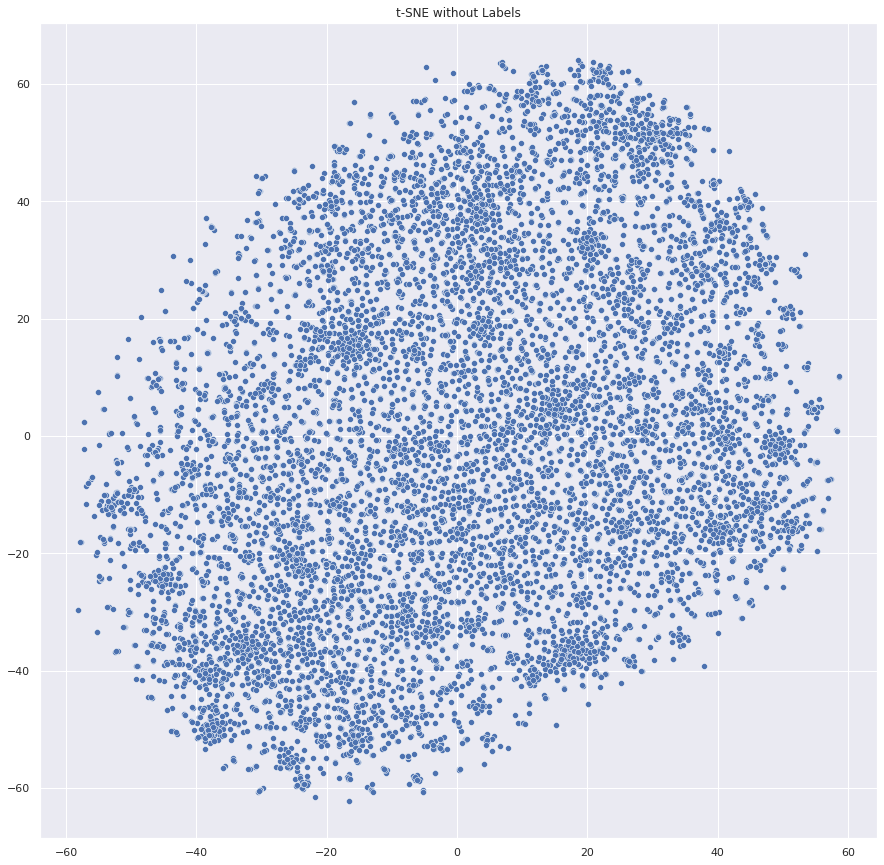

In [36]:
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)
plt.title('t-SNE without Labels')
plt.savefig("t-sne_arxvid.png")
plt.show()

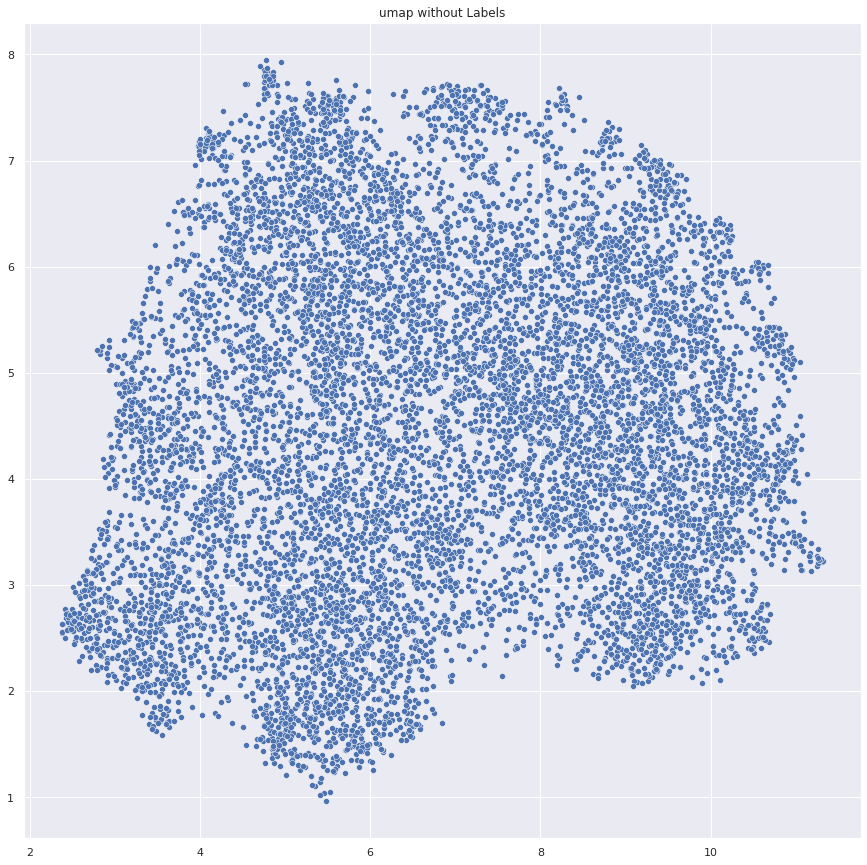

In [37]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], palette=palette)
plt.title('umap without Labels')
plt.savefig("umap_arxvid.png")
plt.show()

## Plot the Clusters

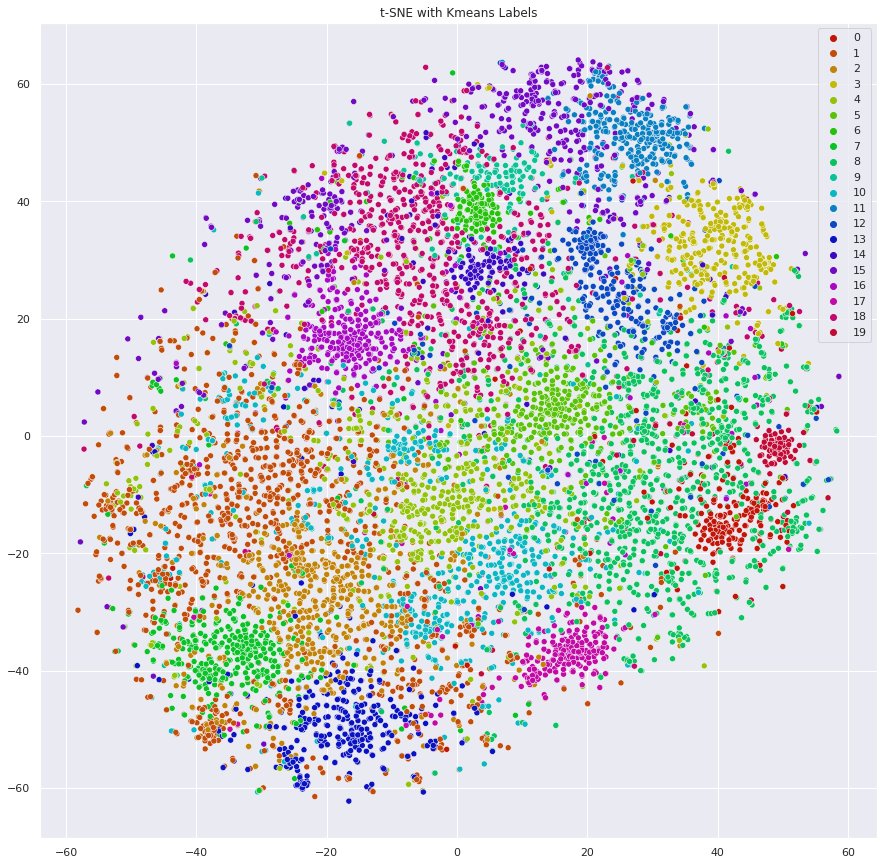

In [38]:
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("cluster_tsne.png")
plt.show()

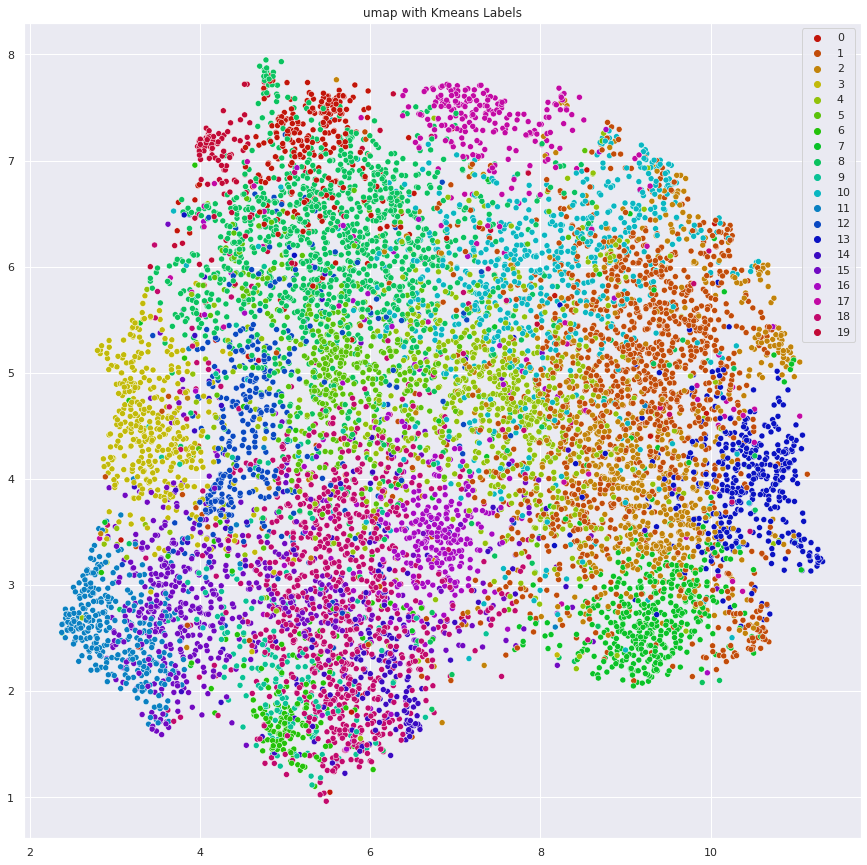

In [39]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('umap with Kmeans Labels')
plt.savefig("cluster_umap_kmeans_labels.png")
plt.show()

The labeled plot gives us the insights of how the papers are grouped. It is difficult to say which dimensional reduction performs better for our data. The performance would have to be evaluated in the upcoming steps.

The location of each paper on the plot was determined by umap / t-SNE while the labels (colors) was determined by k-means. If we look at particular parts of the plot where t-SNE and umap have grouped many articles to form a cluster, it is likely that k-means is in uniform labeling of this cluster.

In other cases, the labels (k-means) are more spread out on the plot (umap /t-SNE). This means that umap / t-SNE and k-means have found differences in the higher dimensional data.

This could be because of certain contents in the papers that are overlaping, so it's hard to separate them. This can be observed in the formation of subclusters on the plot.

The algorithms may find connections that were genuine. This may highlight the shared information that are hidden and advance further research.

# Interactive scatter plot based on t-SNE

In [40]:
import plotly.express as px
fig = px.scatter(df, x=X_embedded[:,0], y=X_embedded[:,1], color=y_pred.astype(str),
                 hover_data=['id', 'authors', 'title',],
                 height= 1000, width=1000,
                title = "t-SNE with Kmeans Labels")
fig.show()